# LSTM baseline

from kuto

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [3]:
import os
import sys
import glob
import pickle
import random

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path


In [5]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [6]:
import pytorch_lightning as pl
# from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger

In [7]:
sys.path.append('../../')
import src.utils as utils

In [8]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [9]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")
WIFI_DIR = DATA_DIR / 'indoorunifiedwifids_original'
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'
OUTPUT_DIR = Path('./output/')
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'

## config

In [10]:
configs = {
    'loss':{
        'name': 'MSELoss',
        'params':{}
    },
    'optimizer':{
        'name': 'Adam',
        'params':{
            'lr': 0.01,
        }
    },

    'scheduler':{
        'name': 'ReduceLROnPlateau',
        'params':{
            'factor': 0.1,
            'patience': 3,
        }
    },

    'loader':{
        'train':{
            'batch_size': 512,
            'shuffle': True,
            'num_workers': 4,
        },
        'valid':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        },
        'test':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        }
    }
}

In [11]:
# config
config = configs

# globals variable
SEED = 777
MAX_EPOCHS = 500
N_SPLITS = 5
DEBUG = False
# EXP_MESSAGE = config['globals']['exp_message']

EXP_NAME = 54
IS_SAVE = True

utils.set_seed(SEED)

In [12]:
!wandb login e8aaf98060af90035c3c28a83b34452780aeec20

/bin/sh: 1: wandb: not found


## read data

In [13]:
train_df = pd.read_csv(WIFI_DIR / 'train_10_th10000_base25_withdelta.csv')
test_df = pd.read_csv(WIFI_DIR / 'test_10_th10000_base25_allwifibase_withdelta.csv')

In [14]:
sub = pd.read_csv(DATA_DIR/'indoor-location-navigation/sample_submission.csv', index_col=0)

BSSIDとRSSIは100ずつ存在しているけど全てが必要なわけではないみたい  
ここでは20だけ取り出している。

In [15]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]
DELTA_FEATS  = ['delta_x', 'delta_y']

In [16]:
train_df.iloc[:, 100:110]

,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9
0,e9b24f94c0007acb4b7169b945622efcd332cf6f,591ea59cf88e3397db5d60eb00a5147edd69399a,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,a77f8e93896f8fc8bc0d0700ca04b802ee79a07f,1b2fd184314ae440900fa9ce1addeb896b5604a9,2c09230bb32ee49f6a72928f6eeefb6885dc15ce,3799b46aa4cf6c3c45c0bc27d8f1efefea96914f,fc6956beb062b5158252c66953e92a0d25495cac,c71a2f5c4282d27f84b9b841db0e310ef0fcf6cd,4f8b7c168dc76c9d3b4ca7903042173e98fe2ddb
1,e9b24f94c0007acb4b7169b945622efcd332cf6f,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,591ea59cf88e3397db5d60eb00a5147edd69399a,d32dd11040b254cd889c9ead2d4a50f6e3900196,9c832009dfb1ee02053c9ce9b7770b6cd3191003,509d1f842b0773e85c6beec0bb530542efd35cb9,1b2fd184314ae440900fa9ce1addeb896b5604a9,f920a2e4cb52165850990d9d37d391b630f7de14,6a42281c99a4cff2ce9dba3fc91ad6a431af64d9,fc6956beb062b5158252c66953e92a0d25495cac
2,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,e9b24f94c0007acb4b7169b945622efcd332cf6f,591ea59cf88e3397db5d60eb00a5147edd69399a,509d1f842b0773e85c6beec0bb530542efd35cb9,b2337b25e7d1df04928bf6698a9c0b2764df7795,76f81d5047273fa64a434457531d400fc5d90fac,6e388d1db5ba8dd9de80522a4ddf50402cf443b3,8c6ab78f2797e076f9106af81090d0ab9904f5cd,ceccac4f0e50ec9e36e8d2800b8f2c7c3b4d903e,f920a2e4cb52165850990d9d37d391b630f7de14
3,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,591ea59cf88e3397db5d60eb00a5147edd69399a,e9b24f94c0007acb4b7169b945622efcd332cf6f,6ec56c3efdeb067eb20bd2f4a6ccdae07d640cc1,d32dd11040b254cd889c9ead2d4a50f6e3900196,f920a2e4cb52165850990d9d37d391b630f7de14,6a42281c99a4cff2ce9dba3fc91ad6a431af64d9,9c832009dfb1ee02053c9ce9b7770b6cd3191003,509d1f842b0773e85c6beec0bb530542efd35cb9,0452e85d0a41780463cfe079077ea5bd2f519c7a
4,5875360455060f20a3cba705f44a4e3987c9b9f3,6ec56c3efdeb067eb20bd2f4a6ccdae07d640cc1,0452e85d0a41780463cfe079077ea5bd2f519c7a,3c7e7fa0576bc8a2af71d5899581df36f4dab6c8,09e103887f42552d20328aa41891cf82dace79ab,54bba3a36204f8c71b93798c31f9e0b039914575,18067f8d8861af3bcae51ba04b6b11b9150b9ff2,591ea59cf88e3397db5d60eb00a5147edd69399a,f920a2e4cb52165850990d9d37d391b630f7de14,d32dd11040b254cd889c9ead2d4a50f6e3900196
...,...,...,...,...,...,...,...,...,...,...
251108,5964a27e0cb3344b0a18540e6b3120c433971c38,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,cce41299a022ada08aebf3d309acb07d5f00b014,346b34a42e801c64e043dbaacbe7fef9b8880774,4b5dbdb52b131410ea10b59ea451de62280b41d6,fa11fc4d4960379cb68cc6968ba6415168fef53c,5f583dcccc43b5b7ac25d270e29c92d878fb2be0,4d2e5639041b40b0df2ee258aa504bd904133d80,dfc21edb1f7650d5645fd672bbe6a13fc6fd77f8,a94eb920c0a198fe8385f3de6a8e8e6d44b6f6c9
251109,5964a27e0cb3344b0a18540e6b3120c433971c38,346b34a42e801c64e043dbaacbe7fef9b8880774,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,cce41299a022ada08aebf3d309acb07d5f00b014,566e0c6e3bcf2b8b3d310d96f111043d17ace817,bd3fc24710537130e97dc2dab4a6bf70b3884a8b,4b5dbdb52b131410ea10b59ea451de62280b41d6,4d2e5639041b40b0df2ee258aa504bd904133d80,f4107af4418d57aacb3542343f7b47768debdc75,5f583dcccc43b5b7ac25d270e29c92d878fb2be0
251110,346b34a42e801c64e043dbaacbe7fef9b8880774,5964a27e0cb3344b0a18540e6b3120c433971c38,cce41299a022ada08aebf3d309acb07d5f00b014,566e0c6e3bcf2b8b3d310d96f111043d17ace817,bd3fc24710537130e97dc2dab4a6bf70b3884a8b,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,4b5dbdb52b131410ea10b59ea451de62280b41d6,a94eb920c0a198fe8385f3de6a8e8e6d44b6f6c9,ee5ca7a7deaacdcd5d99355ff5f156dc45b74efa,a7986c0cea5d2571ea42011ab4407039e977c0bd
251111,346b34a42e801c64e043dbaacbe7fef9b8880774,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,5964a27e0cb3344b0a18540e6b3120c433971c38,f4107af4418d57aacb3542343f7b47768debdc75,cce41299a022ada08aebf3d309acb07d5f00b014,4b5dbdb52b131410ea10b59ea451de62280b41d6,fa11fc4d4960379cb68cc6968ba6415168fef53c,a7986c0cea5d2571ea42011ab4407039e977c0bd,180a351ec58c07d60949862c534373c43f548a9a,4d2e5639041b40b0df2ee258aa504bd904133d80


bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない


In [17]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100, 200):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100, 200):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 61592
BSSID TYPES(test): 28283
BSSID TYPES(all): 89875


In [18]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 97
RSSI TYPES(test): 82
RSSI TYPES(all): 179


## PreProcess

In [19]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
le_rssi = LabelEncoder()
le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,DELTA_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
#     output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
#         output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？
    for i in RSSI_FEATS:
        output_df.loc[:,i] = le_rssi.transform(input_df.loc[:,i])

    # site_idのLE
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
    output_df.loc[:,DELTA_FEATS] = ss.transform(output_df.loc[:,DELTA_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

train  

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,frequency_99,wp_tmestamp,x,y,floor,floor_str,path_id,site_id,delta_x,delta_y
0,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8c1562bec17e1425615f3402f72dded3caa42ce5,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5745,1578469851129,157.99141,102.125390,-1.0,B1,5e158ef61506f2000638fd1f,0,-0.025217,-0.014531
1,b7e6027447eb1f81327d66cfd3adbe557aabf26c,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,5765,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.446463,0.506216
2,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5745,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.446463,0.506216
3,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,5825,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.446463,0.506216
4,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,5765,1578469862177,168.49713,109.861336,-1.0,B1,5e158ef61506f2000638fd1f,0,0.504093,0.398055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251108,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,0a8a55cf161bc4980194ec9f7f7a448439be4b74,1f09251bbfadafb11c63c87963af25238d6bc886,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,da39a3ee5e6b4b0d3255bfef95601890afd80709,1556355684145fce5e67ba749d943a180266ad90,...,0,1573733061352,203.53165,143.513960,6.0,F7,5dcd5c9323759900063d590a,23,0.121631,0.362279
251109,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,4abd3985ba804364272767c04cdc211615f77c56,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,1f09251bbfadafb11c63c87963af25238d6bc886,...,0,1573733070079,192.57130,145.781450,6.0,F7,5dcd5c9323759900063d590a,23,-2.376529,0.568969
251110,4abd3985ba804364272767c04cdc211615f77c56,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd

In [20]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [21]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(int)
        self.delta_feats = df[DELTA_FEATS].values.astype(np.float32)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        concat_feat = np.empty(2 * NUM_FEATS).astype(int)
        concat_feat[0::2] = self.bssid_feats[idx]
        concat_feat[1::2] = self.rssi_feats[idx]
        
        feature = {
            'RSSI_BSSID_FEATS':concat_feat,
            'site_id':self.site_id[idx],
            'delta':self.delta_feats[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'floor':self.floor[idx]
            }
        else:
            target = {}
        return feature, target

In [22]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, bssid_size=94248, site_size=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.bssid_embedding = nn.Embedding(bssid_size, 64, max_norm=True)
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す       
        self.site_embedding = nn.Embedding(site_size, 64, max_norm=True)

        # rssi
        # 次元を64倍に線形変換
#         self.rssi_embedding = nn.Embedding(rssi_size, 64, max_norm=True)
        self.delta = nn.Sequential(
            nn.BatchNorm1d(2),
            nn.Linear(2, 2 * 64)
        )
        
        concat_size = 64 + (2 * NUM_FEATS * 64) + 64 * 2
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(concat_size),
            nn.Dropout(0.3),
            nn.Linear(concat_size, 256),
            nn.ReLU()
        )
        self.bn1 = nn.BatchNorm1d(concat_size)

        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(in_features=concat_size, out_features=256)#, bias=False)
        self.bn2 = nn.BatchNorm1d(256)

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        # self.fc_x = nn.Linear(16, 1)
        # self.fc_y = nn.Linear(16, 1)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_bssid = self.bssid_embedding(x['RSSI_BSSID_FEATS'])
        x_bssid = self.flatten(x_bssid)
        
        x_site_id = self.site_embedding(x['site_id'])
        x_site_id = self.flatten(x_site_id)
        
        x_delta = self.delta(x['delta'])


        x = torch.cat([x_bssid, x_delta, x_site_id], dim=1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        # x_ = self.fc_x(x).view(-1)
        # y_ = self.fc_y(x).view(-1)
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        # return {"x":x_, "y":y_, "floor":floor} 
        return {"xy": xy, "floor": floor}

In [23]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [24]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [25]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["xy"])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["xy"])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)
        
        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return mpe
    
    def validation_epoch_end(self, outputs):
        avg_loss = np.mean(outputs)
        print(f'epoch = {self.current_epoch}, mpe_loss = {avg_loss}')

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [26]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [27]:
oofs = np.zeros((len(train), 2), dtype = np.float32)  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=N_SPLITS)
# for fold, (trn_idx, val_idx) in enumerate(skf.split(train.loc[:, 'path'], train.loc[:, 'path'])):
for fold, (trn_idx, val_idx) in enumerate(gkf.split(train.loc[:, 'path_id'], groups=train.loc[:, 'path_id'])):

    # 指定したfoldのみループを回す

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_df = train.loc[trn_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)
    val_df = train.loc[val_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)
    
    # model
    model = LSTMModel(wifi_bssids_size+rssi_bssids_size, site_count)
    model_name = model.__class__.__name__
    
    # loggers
    RUN_NAME = f'exp{str(EXP_NAME)}'
    wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{fold}')
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        filename=f'{model_name}-{learner.current_epoch}-{fold}')
    callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=True,
        mode='min')
    callbacks.append(early_stop_callback)
    
    trainer = pl.Trainer(
        logger=loggers,
        callbacks=callbacks,
        max_epochs=MAX_EPOCHS,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        fast_dev_run=DEBUG,
        deterministic=True,
        benchmark=True,
#         precision=16,
#         progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
        )


    trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oofs[val_idx, 0] = oof_x
    oofs[val_idx, 1] = oof_y

    
    val_score = mean_position_error(
        oof_x, oof_y, 0,
        val_df['x'].values, val_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############
    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    predictions.append(test_preds)
    

Fold 0


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
wandb: Currently logged in as: sqrt4kaido (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.425    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 165.57604217529297


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 131.17218441597345


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 105.39517121322176


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 91.02603527071551


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 84.65910689630432


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 82.54322781902012


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 82.14607258609564


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 60.2732087259725


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 55.97109465411523


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 53.20298949995272


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 51.930913560343846


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 49.97491927344697


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 48.9955002009779


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 44.5300074174997


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 37.34541454085631


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 31.385618584503955


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 27.00208070993987


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 23.257072047113272


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 20.237413668822096


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 18.098416683624155


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 16.05868912337545


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 14.755124043834202


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 13.713497501789767


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 13.123811458941816


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 12.02474432393297


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 11.510639993293347


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 11.352215762807559


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 10.7363478108014


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 10.276487092420462


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.997196112451773


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.6404601111864


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.54032033975217


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 9.715597636105809


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.234970366188769


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 9.009683910093589


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.048252521062343


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.79556280388618


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.39228854506292


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 9.292742870813694


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.607687789856325


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.167573010719082


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.120349322445492


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.9526419560678185


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 9.122415538913277


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.430964434759197


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.925901404355589


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.7912737407557255


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.806589689199422


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.859739027611548


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.127397730917718


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.270430693184716


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.14396407469457


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.218458349464428


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.114542497913222


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.076418952482786


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.034383490550347


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 6.995669990156687


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 6.984226622838705


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.017626941729279


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 6.9739521005807985


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 6.9876637411148295


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.983720476796953


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 6.942452063336055


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.934281966467455


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 6.9357795897745556


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 6.9341921484037385


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 6.905986442326116


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 6.907835199426585


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.918212032359107


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.907101499785819


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 6.903250671883129


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.897601678349396


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.8841171923079285


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.899748287276762


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.890770928772091


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.905633010532224


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.888121593697927


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.859946233084092


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.857684963676409


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.856016990371399


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.843031363822352


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.858395128231675


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.851618981889159


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.843390246193921


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.8499000501355995


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.846772718911219


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.843249190937389


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.843372130224891


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.843253747483825


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.838672683491595


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.841423501667094


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 6.843092030718484


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 6.8389364991064046


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 6.836366225282992


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 6.838454446048601


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 6.843845040112087


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 6.837534274538434


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 6.8376600234554115


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 6.838097501257121


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 6.838585962051222


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 6.838287954865387


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 6.838016416445973


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 6.8360170983458595


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 6.841052184944227


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 6.840195640348348


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 6.835347540937596


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 6.840862578431586


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 6.83575865337471


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 6.840016915468716


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 6.835778159990685


Validating: 0it [00:00, ?it/s]

epoch = 109, mpe_loss = 6.831872395948521


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 6.843870552693442


Validating: 0it [00:00, ?it/s]

epoch = 111, mpe_loss = 6.842671004977248


Validating: 0it [00:00, ?it/s]

epoch = 112, mpe_loss = 6.841864272904043


Validating: 0it [00:00, ?it/s]

epoch = 113, mpe_loss = 6.83672569706546


Validating: 0it [00:00, ?it/s]

epoch = 114, mpe_loss = 6.844351492055176


Validating: 0it [00:00, ?it/s]

epoch = 115, mpe_loss = 6.836649131959365


Validating: 0it [00:00, ?it/s]

epoch = 116, mpe_loss = 6.837465475944455


Validating: 0it [00:00, ?it/s]

epoch = 117, mpe_loss = 6.836834243976914


Validating: 0it [00:00, ?it/s]

epoch = 118, mpe_loss = 6.841734078118501


Validating: 0it [00:00, ?it/s]

epoch = 119, mpe_loss = 6.845232918522267


Validating: 0it [00:00, ?it/s]

epoch = 120, mpe_loss = 6.840633508750707


Validating: 0it [00:00, ?it/s]

epoch = 121, mpe_loss = 6.844423735344152
fold 0: mean position error 6.841370072328357
Fold 1


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Loss/val,39.86186
Loss/xy,39.86186
Loss/floor,5.61241
MPE/val,6.84137
epoch,121
trainer/global_step,47945
_runtime,599
_timestamp,1619940621
_step,121


Loss/val,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.425    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 140.89785766601562


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 129.06523364255844


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 103.09191444769178


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 88.61944030992913


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 72.27171467556227


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 58.50735165108001


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 47.712468215939104


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 41.89171013913051


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 35.12266329624513


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 29.14375448032218


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 24.286625631850125


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 20.998079799924287


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 18.24906092470957


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 16.338652722993874


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 16.816304353188887


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 13.671172990764108


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 12.608852326934015


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 11.947237954200174


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 11.082054091965336


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 10.36156008665264


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 10.012222013241907


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 11.78560405532801


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 9.27451834708369


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 9.091056008096052


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 8.992311898954396


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 9.13376234506705


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 8.735020758847947


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 8.772920493743458


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.986384589160203


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.173146481004654


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.195316774830264


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.289015629869006


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.071236021770295


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 11.571728206259856


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.168587351675422


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.087123814793317


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 7.864671300309667


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.56433599686433


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 7.994563805526645


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.225933128035559


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.08882513749274


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.389355656717917


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.291994211675274


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.2413916827631635


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.222184374797173


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.198889541646473


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.179993078628202


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.169065620164934


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.166314873878812


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.1760511477737055


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.162025120907539


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.157000335395759


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.1466148900852495


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.1344508623631055


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.1196741323534605


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.126869147243537


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.116199550847968


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.099776969067696


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.121138599030105


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.09620451527515


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.105285468061535


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.092805742423252


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.063915253454144


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.049805927040908


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.048461805844138


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.049976516021033


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.050287733686732


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.044525157244724


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.055857986628101


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.047953827724953


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.04098597793407


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.039135241390632


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.0405044930739065


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.039514115311217


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.035612590026528


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.036795193524404


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.04135230564697


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.037626968515372


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.040848124906014


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.0412130901538355


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.035668082937178


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.034792217469436


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.037509147464498


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.042766877971053


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.043898119148633


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.038363384734218


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.032496571105295


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.046115155120627


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.042594027114432


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.038971128449398


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.035803555263747


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.043833133407287


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.043201812487531


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.03572925172671


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 7.036835866463254


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 7.040546974161223


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 7.047139991720902


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 7.035712936015225


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 7.041280348993182


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 7.035718554813017


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 7.043549001895815


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 7.0341294316509675


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 7.0311336230391355


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 7.039861401460158


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 7.043224578976708


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 7.038207634069729


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 7.043459757563634
fold 1: mean position error 7.018736605966815
Fold 2


Loss/val,39.95226
Loss/xy,39.95226
Loss/floor,4.93053
MPE/val,7.01874
epoch,105
trainer/global_step,41657
_runtime,529
_timestamp,1619941158
_step,105


Loss/val,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,██▁▃▄▃▃▃▄▄▄▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
MPE/val,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.425    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 170.1674346923828


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 126.06577335581483


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 100.81427398589818


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 86.85200483968585


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 70.6983797650119


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 62.764578887936175


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 53.922236902288994


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 47.98003857668154


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 44.18307787368253


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 40.59197134657007


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 37.30486284551532


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 29.979923646116475


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 24.448874038853695


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 20.56955278444977


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 18.03074416329265


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 15.681391788148993


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 14.051205601457522


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 13.158163596501074


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 12.315793241553735


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 11.637269857030722


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 11.165780684882892


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 10.617437940552854


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 10.745008595497563


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 9.931097262858216


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 10.530883949442934


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 9.290393600918877


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 9.332742584666308


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 9.118354917776704


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.716805916152255


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.490183533173132


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.631507659250502


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.610937698461818


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 9.030841276360254


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.595717815540182


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.340993646854947


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.217216030233988


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.375612632448945


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.268895623916045


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.28411748438478


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.384012219318134


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.441992473786758


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.343814530834802


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.133522349533255


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.590248172779686


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.093737639331469


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.849835542256208


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.881634795432601


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.626256950127548


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.519402597940996


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.125827591521187


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.8631109726088235


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.220831829016117


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.023228073796481


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.562036376037367


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 8.013029333496258


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.392826135558721


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.314144004270028


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.250563012997668


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.225692897516247


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.237102232465123


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.224816893854886


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.201598741202208


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.1986767114835635


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.201020945535279


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.192746942488578


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.201174688779896


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.198487241012472


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.175827055778807


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.190610020180659


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.153847428052727


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.150950848505416


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.147323771648296


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.160631460398467


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.154732688688192


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.151741614578464


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.11488971550337


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.112181022298892


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.113193173626789


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.1044305832237935


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.113160366861378


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.109630999143934


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.104083940287495


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.102322861990979


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.098145708432127


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.1049617175617295


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.1040232949633


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.104963157962477


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.103500417040774


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.09490279692259


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.099821978990631


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.10415131272538


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.091005018493731


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.096284826827157


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.090159679878509


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 7.091416351159311


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 7.087975686579758


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 7.0927129746405715


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 7.09203615681525


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 7.095362473015833


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 7.098768697409073


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 7.096570970779999


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 7.090623209252553


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 7.09101801069224


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 7.099671753765101


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 7.096119139339497


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 7.0914879966340685


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 7.094597017537028


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 7.093758021788573


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 7.087433543021823


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 7.088097965028141


Validating: 0it [00:00, ?it/s]

epoch = 109, mpe_loss = 7.093530446361425


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 7.101298282255595


Validating: 0it [00:00, ?it/s]

epoch = 111, mpe_loss = 7.099205409227688


Validating: 0it [00:00, ?it/s]

epoch = 112, mpe_loss = 7.095121745829579


Validating: 0it [00:00, ?it/s]

epoch = 113, mpe_loss = 7.093121850154949


Validating: 0it [00:00, ?it/s]

epoch = 114, mpe_loss = 7.092068987304668


Validating: 0it [00:00, ?it/s]

epoch = 115, mpe_loss = 7.091748171920498


Validating: 0it [00:00, ?it/s]

epoch = 116, mpe_loss = 7.102818428509317


Validating: 0it [00:00, ?it/s]

epoch = 117, mpe_loss = 7.090510036006118


Validating: 0it [00:00, ?it/s]

epoch = 118, mpe_loss = 7.094256219160883


Validating: 0it [00:00, ?it/s]

epoch = 119, mpe_loss = 7.094330215515589


Validating: 0it [00:00, ?it/s]

epoch = 120, mpe_loss = 7.0971564109059475


Validating: 0it [00:00, ?it/s]

epoch = 121, mpe_loss = 7.090445095355758


Validating: 0it [00:00, ?it/s]

epoch = 122, mpe_loss = 7.092034152725961


Validating: 0it [00:00, ?it/s]

epoch = 123, mpe_loss = 7.092359830404184


Validating: 0it [00:00, ?it/s]

epoch = 124, mpe_loss = 7.0888323959626875


Validating: 0it [00:00, ?it/s]

epoch = 125, mpe_loss = 7.095601088048155


Validating: 0it [00:00, ?it/s]

epoch = 126, mpe_loss = 7.097585596629376


Validating: 0it [00:00, ?it/s]

epoch = 127, mpe_loss = 7.100621903708692
fold 2: mean position error 7.068759755568613
Fold 3


Loss/val,41.65643
Loss/xy,41.65643
Loss/floor,4.76923
MPE/val,7.06876
epoch,127
trainer/global_step,50303
_runtime,638
_timestamp,1619941804
_step,127


Loss/val,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,██▄▁▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
MPE/val,█▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.425    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 129.39268493652344


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 134.30428634697165


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 110.65761057535808


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 89.54985675384562


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 75.56671502938855


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 66.82591406294898


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 61.33136527078634


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 57.05059372546331


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 54.54708641414114


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 52.565484835591604


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 51.21130055128926


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 49.83655370972792


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 38.88736716141866


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 33.062752515116856


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 28.35066079025369


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 24.990940679098674


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 21.470901077339196


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 18.55696410655347


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 16.4146105649443


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 14.59310162062178


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 13.652260276063997


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 12.734164195883729


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 11.428621290648355


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 11.0740945455428


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 10.790142114192811


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.194563663367068


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 10.390765902343736


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 9.994991957958089


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 9.536115088481676


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.310474815209497


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.041094712746158


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.566280638276353


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 9.357787341259003


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.85292639478969


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.70214577814336


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.773383778231574


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.696540860581095


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.720017773046482


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.676330278042277


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.529298915326937


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.371772083630937


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.248152961320503


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.570343154325892


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.740485480337432


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.606443274895454


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.080292374615508


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.161293444007335


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.990749493156236


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.117398654257565


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.198587720625538


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 10.937348480961749


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.94788776032486


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.717778277700807


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.663238678472735


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.734424009729384


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 9.457406663873712


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 8.024103499108048


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.038737496630267


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.2894728475879775


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.17164694221071


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.126489305475275


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.090393662190929


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.056006672825267


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.039664548481039


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.009188812869025


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.035245336458042


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.043083195525091


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.000931106327812


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.031220518814978


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.994880694907435


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 6.987467191383721


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.986106649531992


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.98768389010356


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.991591872800376


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.98084021871112


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.983662601516181


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.980873096392351


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.976267149954131


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.970635436740317


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.9717433769869395


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.968184394694024


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.9793324399319046


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.973956032075743


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.970683698021743


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.973011873351622


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.972973744388626


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.969062517230637


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.965654469499684


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.972824137306129


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.966654828624031


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.966708315010389


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 6.976844887907274


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 6.963554733303172


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 6.970723260009189


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 6.972730726854394


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 6.965607773592768


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 6.9708559572775215


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 6.967658212114752


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 6.97519807748539


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 6.9645738626814335
fold 3: mean position error 6.966772099504728
Fold 4


Loss/val,38.71164
Loss/xy,38.71164
Loss/floor,4.6239
MPE/val,6.96677
epoch,98
trainer/global_step,38906
_runtime,500
_timestamp,1619942312
_step,98


Loss/val,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▇██▇▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
MPE/val,█▆▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.425    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 127.99514770507812


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 120.18094655699932


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 93.50353428937386


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 81.59230230647218


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 64.36153174389021


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 58.14280975519381


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 54.62272286278981


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 52.497029286913566


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 42.23562190843665


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 34.446966687681176


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 28.928608976438685


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 23.72356189004046


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 19.815818215756757


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 17.23030937016403


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 15.156051746313121


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 13.45348472096808


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 12.915557456948436


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 11.839022209417102


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 11.45215100806483


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 11.008657724123331


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 9.907508005528372


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 9.55119807918081


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 9.596019067626068


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 9.317125403991016


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 9.096012203642083


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 8.869309727958173


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 10.583910827737238


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 8.505919547786721


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.282582836712354


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.357432106580973


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.574398053336363


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.528659892804695


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.138412180101867


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.036735273109072


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.096143616570366


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.512072682118909


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.695256194683036


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.446628018330207


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 7.481133054315285


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 7.398708129693502


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 7.367843944774053


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.334363928687222


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.31406973127634


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.294818345527665


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.320667762949009


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.3099155646957845


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.316394057669659


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.260408010930935


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.265310088950498


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.26924542517949


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.282664019861502


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.267658541482114


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.229166526149437


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.213457163876487


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.206800024604713


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.2029606494978955


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.2194168806390175


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.2290369168048265


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.214771731359476


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.210160654367037


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.216870545817406


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.222139200621862


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.21713255642274


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.219650867271172


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.219396650136748


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.228183072650961


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.217591951330032


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.216868457534516


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.2110114571919395


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.219153143095771


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.220772570039182


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.219281002257444


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.20814126334695


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.203770949958865


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.211097526613117


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.222433986923492
fold 4: mean position error 7.241599937619603


In [28]:
oofs_df = pd.DataFrame(oofs, columns=['x', 'y'])
oofs_df['path'] = train_df['path_id']
oofs_df['timestamp'] = train_df['wp_tmestamp']
oofs_df['site'] = train_df['site_id']
oofs_df['site_path_timestamp'] = oofs_df['site'] + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df['floor'] = train_df['floor']
oofs_df.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv", index=False)
oofs_df

,x,y,path,timestamp,site,site_path_timestamp,floor
0,160.326752,101.194542,5e158ef61506f2000638fd1f,1578469851129,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
1,161.153412,105.904617,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
2,163.719131,112.398659,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
3,163.259323,108.695564,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
4,163.408676,111.861694,5e158ef61506f2000638fd1f,1578469862177,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
...,...,...,...,...,...,...,...
251108,195.873962,138.694031,5dcd5c9323759900063d590a,1573733061352,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
251109,190.843948,142.983002,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
251110,190.292130,141.470215,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
251111,186.113220,138.429688,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0


In [29]:
oofs_df_dupli = oofs_df[~oofs_df.duplicated(subset='timestamp')].sort_values('timestamp').reset_index(drop=True)

In [30]:
oofs_df_dupli[['path', 'timestamp', 'site']]

,path,timestamp,site
0,5d08a2553f461f0008dac591,1560495549579,5c3c44b80379370013e0fd2b
1,5d08a2553f461f0008dac591,1560495574531,5c3c44b80379370013e0fd2b
2,5d073b814a19c000086c558b,1560500995805,5c3c44b80379370013e0fd2b
3,5d073b814a19c000086c558b,1560501011427,5c3c44b80379370013e0fd2b
4,5d073b821a69370008bc5cf8,1560501353313,5c3c44b80379370013e0fd2b
...,...,...,...
70727,5e15bf91f4c3420006d52341,1578483551384,5a0546857ecc773753327266
70728,5e15bf91f4c3420006d52341,1578483556553,5a0546857ecc773753327266
70729,5e15bf91f4c3420006d52341,1578483567957,5a0546857ecc773753327266
70730,5e15bf91f4c3420006d52341,1578483574917,5a0546857ecc773753327266


In [31]:
oofs_df_gby = oofs_df.groupby('timestamp').mean()[['x', 'y']].sort_index().reset_index(drop=True)
oofs_df_gby[['path', 'timestamp', 'site', 'site_path_timestamp', 'floor']] = oofs_df_dupli[['path', 'timestamp', 'site', 'site_path_timestamp', 'floor']]
oofs_df_gby.to_csv(str(OUTPUT_DIR) + f"/oof_gby{EXP_NAME}.csv", index=False)
oofs_df_gby

,x,y,path,timestamp,site,site_path_timestamp,floor
0,165.515152,40.187908,5d08a2553f461f0008dac591,1560495549579,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0
1,188.398544,33.055405,5d08a2553f461f0008dac591,1560495574531,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0
2,193.218109,89.314255,5d073b814a19c000086c558b,1560500995805,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0
3,186.717194,86.364700,5d073b814a19c000086c558b,1560501011427,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0
4,186.101135,85.728470,5d073b821a69370008bc5cf8,1560501353313,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,2.0
...,...,...,...,...,...,...,...
70727,64.717354,178.085770,5e15bf91f4c3420006d52341,1578483551384,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
70728,62.083721,178.717041,5e15bf91f4c3420006d52341,1578483556553,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
70729,51.080460,181.193924,5e15bf91f4c3420006d52341,1578483567957,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
70730,43.023487,182.947403,5e15bf91f4c3420006d52341,1578483574917,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0


In [32]:
train_df_gby = train_df.groupby('wp_tmestamp').mean()[['x', 'y']]

In [33]:
oofs_score = mean_position_error(
        oofs_df['x'], oofs_df['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
oofs_score_gby = mean_position_error(
        oofs_df_gby['x'], oofs_df_gby['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}, CV_gby:{oofs_score_gby}")

CV:7.027447083012028, CV_gby:6.492813809400649


In [34]:
fold_mean_xy = 0
for i in range(len(predictions)):
    fold_mean_xy += predictions[i][['x', 'y']]
fold_mean_xy = fold_mean_xy / 5
fold_mean_xy

,x,y
0,70.826523,86.271774
1,78.395210,85.591370
2,71.692406,84.318436
3,68.977089,81.750175
4,71.107201,83.229691
...,...,...
37395,131.402954,183.938019
37396,132.909958,180.951141
37397,132.653030,177.574295
37398,130.252228,173.830261


In [35]:
fold_mean_xy['site_path_timestamp'] = predictions[0]['site_path_timestamp']

In [36]:
all_preds = fold_mean_xy.groupby('site_path_timestamp').mean()

In [37]:
# all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean()
# all_preds

In [38]:
all_preds_50 = pd.read_csv('../50/output/sub50.csv', index_col=0)
all_preds_50.index = pd.read_csv(WIFI_DIR / 'test_7_th20000.csv')['site_path_timestamp']
all_preds_50

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,85.71397,104.649240
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,80.89932,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,85.22545,105.812570
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,88.35129,107.935360
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,87.31835,108.258490
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,210.10178,100.415660
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,208.61255,101.582490
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,205.28879,106.346170


In [39]:
all_preds_merge = pd.merge(all_preds_50, all_preds, how='left', on='site_path_timestamp')[['floor', 'x_y', 'y_y']]
all_preds_merge = all_preds_merge.rename(columns={'x_y': 'x', 'y_y': 'y'})
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,NaN,NaN
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,208.028809,98.691971
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,208.221573,101.358078
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,203.621933,107.754578


In [40]:
all_preds_merge['floor'].fillna(all_preds_50['floor'], inplace=True)
all_preds_merge['x'].fillna(all_preds_50['x'], inplace=True)
all_preds_merge['y'].fillna(all_preds_50['y'], inplace=True)
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,85.713966,104.649239
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,80.899323,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,85.225449,105.812569
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,88.351288,107.935364
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,87.318352,108.258492
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,208.028809,98.691971
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,208.221573,101.358078
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,203.621933,107.754578


In [41]:
# foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
all_preds_merge.index = sub.index
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,85.713966,104.649239
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,80.899323,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.225449,105.812569
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,88.351288,107.935364
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,87.318352,108.258492
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,208.028809,98.691971
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,208.221573,101.358078
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,203.621933,107.754578


In [42]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv('../01/submission.csv')
all_preds_merge['floor'] = simple_accurate_99['floor'].values
all_preds_merge.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,85.713966,104.649239
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,80.899323,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.225449,105.812569
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,88.351288,107.935364
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,87.318352,108.258492
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,208.028809,98.691971
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,208.221573,101.358078
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,203.621933,107.754578


# Post Proccess

In [43]:
oofs_df = pd.read_csv(str(OUTPUT_DIR) + f"/oof_gby{EXP_NAME}.csv")
sub_df = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")

In [44]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [45]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state is 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)

In [46]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

In [47]:
def correct_path(args):

    path, path_df = args
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    txt_path = path_df['txt_path'].values[0]
    
    example = read_data_file(txt_path)
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [48]:
tmp = sub_df['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub_df['site'] = tmp[0]
sub_df['path'] = tmp[1]
sub_df['timestamp'] = tmp[2].astype(float)

In [49]:
used_buildings = sorted(sub_df['site'].value_counts().index.tolist())
test_txts = sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/test/*.txt'))
train_txts = [sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/train/{used_building}/*/*.txt')) for used_building in used_buildings]
train_txts = sum(train_txts, [])

In [50]:
txt_pathes = []
for path in tqdm(sub_df['path'].values):
    txt_pathes.append([test_txt for test_txt in test_txts if path in test_txt][0])

100%|██████████| 10133/10133 [00:00<00:00, 28625.89it/s]


In [51]:
sub_df['txt_path'] = txt_pathes

In [52]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub_df_cm = pd.concat(dfs).sort_values('site_path_timestamp')

626it [02:24,  4.34it/s]


In [53]:
txt_pathes = []
for path in tqdm(oofs_df['path'].values):
    txt_pathes.append([train_txt for train_txt in train_txts if path in train_txt][0])

100%|██████████| 70732/70732 [00:41<00:00, 1704.28it/s]


In [54]:
oofs_df['txt_path'] = txt_pathes

In [55]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, oofs_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
oofs_df_cm = pd.concat(dfs).sort_index()
oofs_df_cm

10789it [16:50, 10.68it/s]


,site_path_timestamp,floor,x,y
0,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,164.559645,36.842270
1,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,187.514165,27.923581
2,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,195.621748,89.201711
3,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,182.737862,85.519369
4,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,2.0,181.199319,85.720912
...,...,...,...,...
70727,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,64.796879,177.976204
70728,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,59.490760,179.756470
70729,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,50.971239,182.387402
70730,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,45.675051,184.684902


In [56]:
oofs_df_cm.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm_gby.csv", index=False)

In [57]:
oofs_score = mean_position_error(
        oofs_df_cm['x'], oofs_df_cm['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}")

CV:5.389434669465558


In [58]:
sub_df_cm.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv", index=False)

In [59]:
oofs_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm_gby.csv")

In [60]:
sub_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv")

In [61]:
def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

In [62]:
train_waypoints = pd.read_csv(str(DATA_DIR/'indoor-location-navigation') + '/train_waypoints.csv')


In [63]:
sub_df_cm = sub_process(sub_df_cm, train_waypoints)
oofs_df_cm = sub_process(oofs_df_cm, train_waypoints)

In [64]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub_df_cm = add_xy(sub_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(sub_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub_df_cm_ds = pd.concat(ds)


oofs_df_cm = add_xy(oofs_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(oofs_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

oofs_df_cm_ds = pd.concat(ds)

  0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [65]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()



In [66]:
# Calculate the distances
sub_df_cm_ds['dist'] = np.sqrt( (sub_df_cm_ds.x-sub_df_cm_ds.x_)**2 + (sub_df_cm_ds.y-sub_df_cm_ds.y_)**2 )
sub_pp = snap_to_grid(sub_df_cm_ds, threshold=5)
sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

# Calculate the distances
oofs_df_cm_ds['dist'] = np.sqrt( (oofs_df_cm_ds.x-oofs_df_cm_ds.x_)**2 + (oofs_df_cm_ds.y-oofs_df_cm_ds.y_)**2 )
oofs_pp = snap_to_grid(oofs_df_cm_ds, threshold=5)
oofs_pp = oofs_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

In [67]:
sub_pp = sub_pp.sort_index()
sub_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,79.662285,102.766754,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,87.162830,104.450550,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.596040,98.605774,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.627910,102.635210,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.511300,107.841324,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,192.553130,111.863014,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6


In [68]:
sub_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_pp.csv", index=False)

In [69]:
oofs_pp = oofs_pp.sort_index()
oofs_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,163.710890,36.197370,5c3c44b80379370013e0fd2b,5d08a2553f461f0008dac591,F1
1,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,183.158980,28.152115,5c3c44b80379370013e0fd2b,5d08a2553f461f0008dac591,F1
2,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,195.909590,90.654030,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,F3
3,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,181.347610,84.303024,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,F3
4,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,2.0,181.347610,84.303024,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,F3
...,...,...,...,...,...,...,...
70727,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,68.407646,177.942440,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1
70728,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,61.413883,176.395230,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1
70729,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,47.679752,178.775450,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1
70730,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,49.308346,187.129460,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1


In [70]:
oofs_score = mean_position_error(
        oofs_pp['x'], oofs_pp['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}")

CV:4.855816246392979


In [71]:
oofs_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_pp_gby.csv", index=False)

In [72]:
wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type='summary')
wandb.run.name = 'summary'
wandb.log({'CV_score': oofs_score})
wandb.save(utils.get_notebook_path())
wandb.finish()

Loss/val,42.6582
Loss/xy,42.6582
Loss/floor,5.13563
MPE/val,7.07025
epoch,116
trainer/global_step,45980
_runtime,557
_timestamp,1619849215
_step,116


Loss/val,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,█▇▇▇▆▅▃▂▂▁▁▂▂▂▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
MPE/val,█▅▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


CV_score,4.85582
_runtime,2
_timestamp,1619850769
_step,0


CV_score,▁
_runtime,▁
_timestamp,▁
_step,▁


In [75]:
import matplotlib.pylab as plt

In [97]:
bad_index = np.union1d(np.where(np.abs(train_df['x'].values - oofs_df['x']) > 20)[0], np.where(np.abs(train_df['y'].values - oofs_df['y']) > 20)[0])

In [98]:
np.save(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_badindex.npy", bad_index)

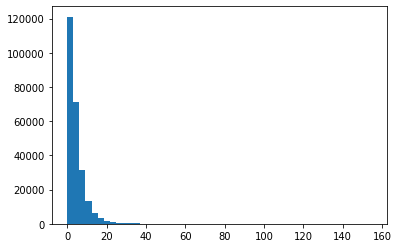

,count,mean,std,min,25%,50%,75%,max
x,251113.0,4.545734,5.041066,0.000034,1.487285,3.239056,5.944255,154.648984


In [87]:
plt.hist(np.abs(train_df['x'].values - oofs_df['x']), bins=50)
plt.show()
pd.DataFrame(np.abs(train_df['x'].values - oofs_df['x'])).describe().T

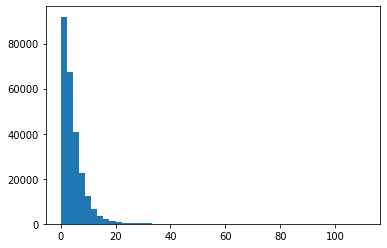

,count,mean,std,min,25%,50%,75%,max
y,251113.0,4.353171,4.28775,0.000007,1.470318,3.208053,5.868435,110.983953


In [88]:
plt.hist(np.abs(train_df['y'].values - oofs_df['y']), bins=50)
plt.show()
pd.DataFrame(np.abs(train_df['y'].values - oofs_df['y'])).describe().T

In [ ]:
import json
import matplotlib.pylab as plt

def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base=str(DATA_DIR/'indoor-location-navigation'),
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

In [ ]:
example_site = '5a0546857ecc773753327266'
example_floorNo = 'F1'

sub_df = sub_process(sub_df, train_waypoints)
plot_preds(example_site, example_floorNo, sub_df,
           train_waypoints, show_preds=True)

In [ ]:
plot_preds(example_site, example_floorNo, sub_df_cm,
           train_waypoints, show_preds=True)

In [ ]:
plot_preds(example_site, example_floorNo, sub_pp,
           train_waypoints, show_preds=True)